# Modelos de regressão para séries temporal


In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
import numpy as np

## Dados

In [179]:
df = pd.read_csv("data_updated.csv")
df

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458



Plota volume, inv e users juntos no mesmo gráfico

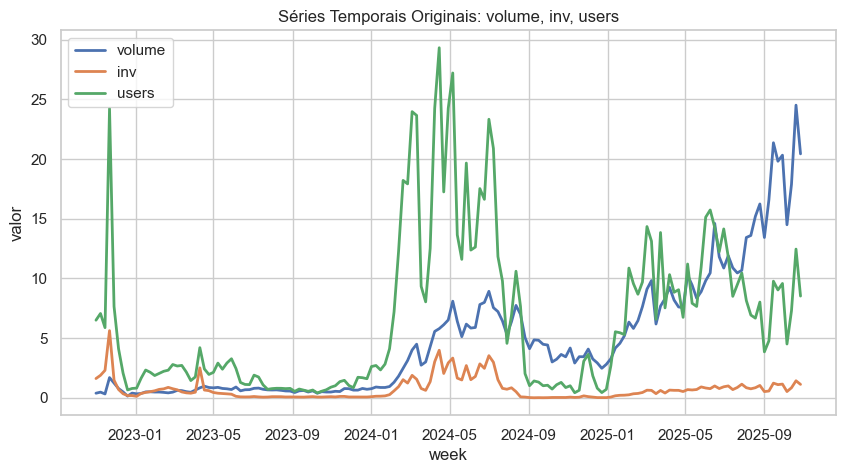

In [180]:
# Carrega dados
df = pd.read_csv("data_updated.csv", parse_dates=['week'])
df = df.sort_values("week").set_index("week")

# ---------- Plot das três séries no mesmo padrão ----------
plt.figure(figsize=(10,5))

plt.plot(df.index, df['volume'], label='volume', linewidth=2)
plt.plot(df.index, df['inv'], label='inv', linewidth=2)
plt.plot(df.index, df['users'], label='users', linewidth=2)

plt.title("Séries Temporais Originais: volume, inv, users")
plt.xlabel("week")
plt.ylabel("valor")
plt.grid(True)
plt.legend()
plt.show()


Explorando relações entre volume e outras variáveis: Scatter com reta de regressão entre volume e inv; volume e users

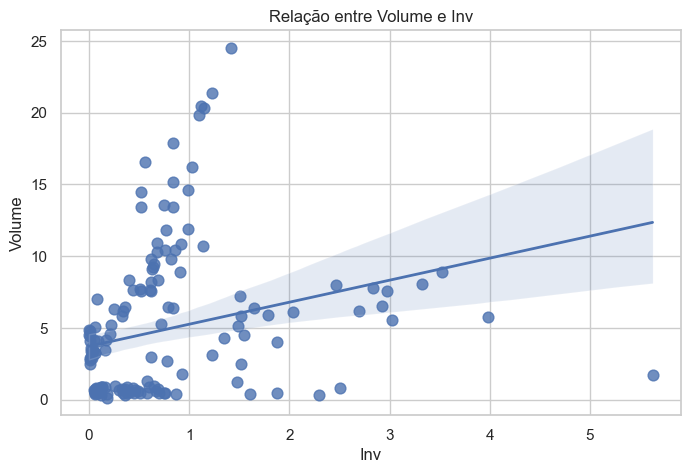

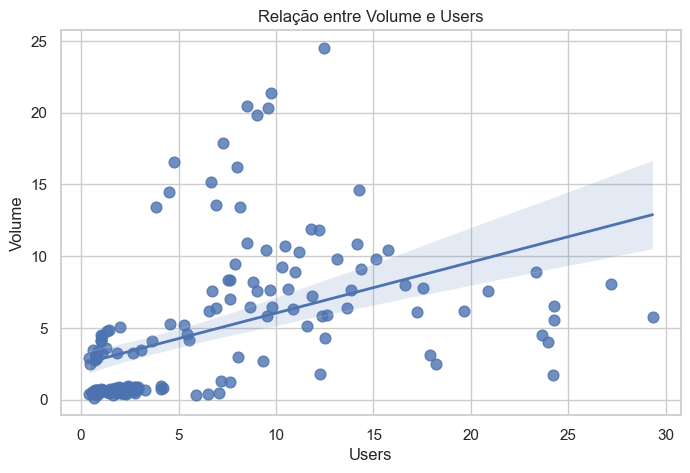

In [181]:
df = pd.read_csv("data_updated.csv")
df['week'] = pd.to_datetime(df['week'])

# volume vs inv
plt.figure(figsize=(8,5))
sns.regplot(
    data=df,
    x='inv',
    y='volume',
    ci=95,       # intervalo de confiança
    scatter_kws={'s':60},
    line_kws={'linewidth':2}
)
plt.title("Relação entre Volume e Inv")
plt.xlabel("Inv")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

#  volume vs users
plt.figure(figsize=(8,5))
sns.regplot(
    data=df,
    x='users',
    y='volume',
    ci=95,
    scatter_kws={'s':60},
    line_kws={'linewidth':2}
)
plt.title("Relação entre Volume e Users")
plt.xlabel("Users")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


## Modelos de regressão

### Regressão linear simples

Ajustamos uma regressão linear simples que considera apenas a variável volume e a variável temporal

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv("data_updated.csv")
df = df.copy()

df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week')

# Agora podemos criar 't' e a coluna de estação
df['t'] = np.arange(1, len(df)+1)
df['season'] = df.index.month

df['t'] = np.arange(1, len(df)+1)
h=4
train = df.iloc[:-h].copy()   # todo o conjunto menos os últimos h pontos
test  = df.iloc[-h:].copy()   # últimos h pontos para teste
# h = len(test)  # horizonte = tamanho do teste
X_cols = ['inv', 'users', 't']

# -----------------------------------------------------------
# Modelo 1: Regressão simples
# -----------------------------------------------------------
X_train_s = sm.add_constant(train['t'])
model_simple = sm.OLS(train['volume'], X_train_s).fit()

X_test_s = sm.add_constant(test['t'])
pred_test_simple = model_simple.get_prediction(X_test_s).summary_frame(alpha=0.05)

# Erros de teste
y_true_s = test['volume']
y_pred_s = pred_test_simple['mean']
rmse_s = np.sqrt(np.mean((y_true_s - y_pred_s)**2))
mae_s = np.mean(np.abs(y_true_s - y_pred_s))
mape_s = np.mean(np.abs((y_true_s - y_pred_s)/y_true_s))*100
print(f"Modelo Simples - RMSE: {rmse_s:.2f}, MAE: {mae_s:.2f}, MAPE: {mape_s:.2f}%")

Modelo Simples - RMSE: 8.82, MAE: 8.06, MAPE: 39.60%


### Regressão linear múltipla

Ajustamos uma regressão linear múltipla que considera também as covariáveis inv e users 

In [183]:
# -----------------------------------------------------------
# Modelo 2: Regressão múltipla
# -----------------------------------------------------------
X_train_m = sm.add_constant(train[X_cols])
model_multi = sm.OLS(train['volume'], X_train_m).fit()

X_test_m = sm.add_constant(test[X_cols])
X_test_m = X_test_m.reindex(columns=X_train_m.columns, fill_value=0)
pred_test_multi = model_multi.get_prediction(X_test_m).summary_frame(alpha=0.05)

y_true_m = test['volume']
y_pred_m = pred_test_multi['mean']
rmse_m = np.sqrt(np.mean((y_true_m - y_pred_m)**2))
mae_m = np.mean(np.abs(y_true_m - y_pred_m))
mape_m = np.mean(np.abs((y_true_m - y_pred_m)/y_true_m))*100
print(f"Modelo Múltiplo - RMSE: {rmse_m:.2f}, MAE: {mae_m:.2f}, MAPE: {mape_m:.2f}%")

Modelo Múltiplo - RMSE: 8.08, MAE: 7.43, MAPE: 36.68%


#### Incluir efeito sazonal

Ajustamos uma regressão linear múltipla que considera também o efeito sazonal dos dados

(com tendência + múltipla + efeito sazonal)

In [184]:
# -----------------------------------------------------------
# Modelo 3: Múltiplo + sazonalidade
# -----------------------------------------------------------
# Criar dummies de estação (mês)
train['season'] = train.index.month
test['season']  = test.index.month

season_dummies_train = pd.get_dummies(train['season'], prefix="season", drop_first=True).astype(float)
season_dummies_test  = pd.get_dummies(test['season'], prefix="season", drop_first=True).astype(float)

X_train_m3 = pd.concat([train[['inv','users','t']].astype(float), season_dummies_train], axis=1)
X_train_m3 = sm.add_constant(X_train_m3)

model_multi_season = sm.OLS(train['volume'].astype(float), X_train_m3).fit()

X_test_m3 = pd.concat([test[['inv','users','t']].astype(float), season_dummies_test], axis=1)
X_test_m3 = X_test_m3.reindex(columns=X_train_m3.columns, fill_value=0)
pred_test_m3 = model_multi_season.get_prediction(X_test_m3).summary_frame(alpha=0.05)

y_true_m3 = test['volume']
y_pred_m3 = pred_test_m3['mean']
rmse_m3 = np.sqrt(np.mean((y_true_m3 - y_pred_m3)**2))
mae_m3 = np.mean(np.abs(y_true_m3 - y_pred_m3))
mape_m3 = np.mean(np.abs((y_true_m3 - y_pred_m3)/y_true_m3))*100
print(f"Modelo Múltiplo + Sazonalidade - RMSE: {rmse_m3:.2f}, MAE: {mae_m3:.2f}, MAPE: {mape_m3:.2f}%")

Modelo Múltiplo + Sazonalidade - RMSE: 6.11, MAE: 5.23, MAPE: 24.88%


## Resultados

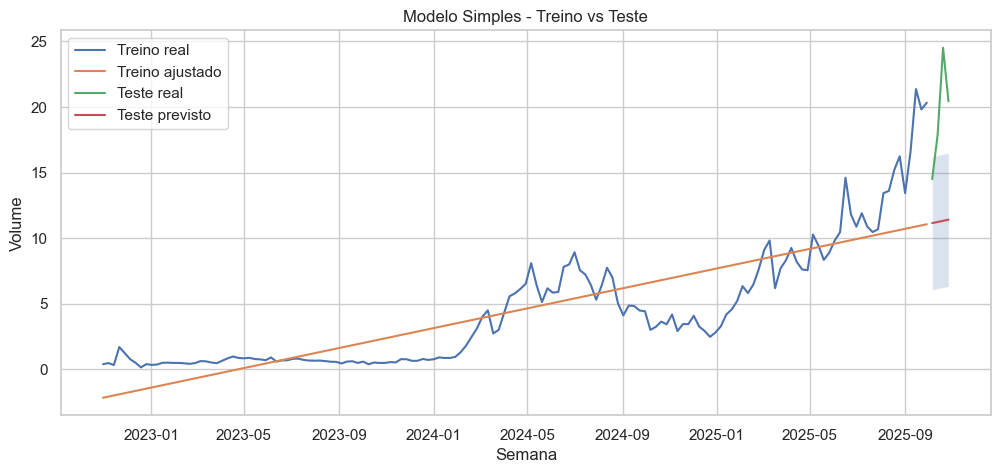

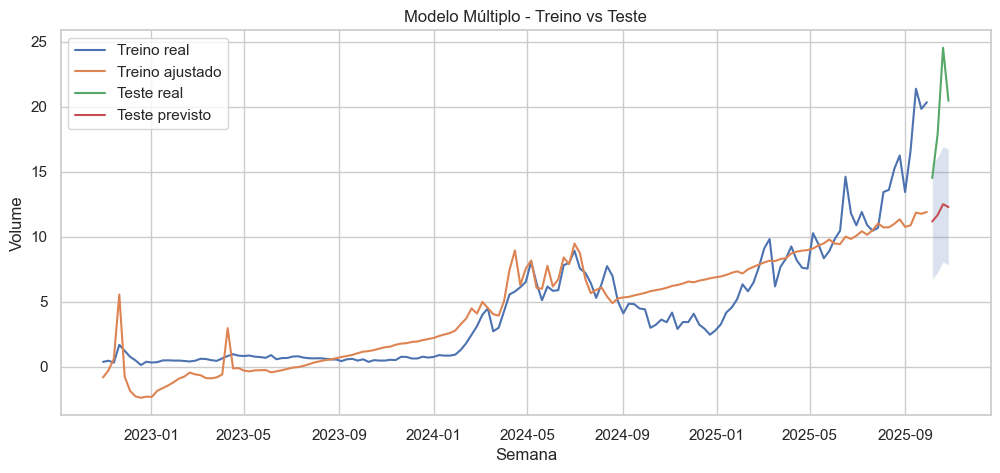

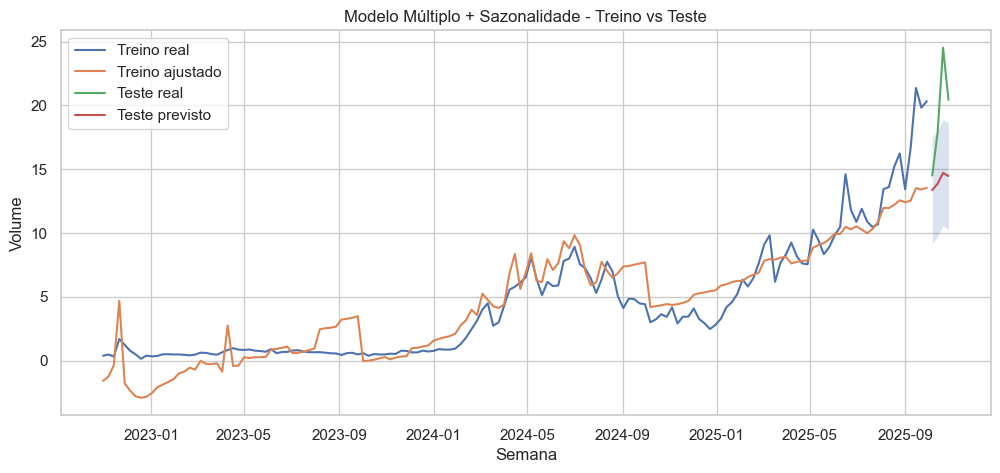

Sumários salvos.


In [ ]:
# Modelo simples
plt.figure(figsize=(12,5))
plt.plot(train.index, train['volume'], label='Treino real')
plt.plot(train.index, model_simple.fittedvalues, label='Treino ajustado')
plt.plot(test.index, y_true_s, label='Teste real')
plt.plot(test.index, y_pred_s, label='Teste previsto')
plt.fill_between(test.index, pred_test_simple['obs_ci_lower'], pred_test_simple['obs_ci_upper'], alpha=0.2)
plt.title("Modelo Simples - Treino vs Teste")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

# Modelo múltiplo
plt.figure(figsize=(12,5))
plt.plot(train.index, train['volume'], label='Treino real')
plt.plot(train.index, model_multi.fittedvalues, label='Treino ajustado')
plt.plot(test.index, y_true_m, label='Teste real')
plt.plot(test.index, y_pred_m, label='Teste previsto')
plt.fill_between(test.index, pred_test_multi['obs_ci_lower'], pred_test_multi['obs_ci_upper'], alpha=0.2)
plt.title("Modelo Múltiplo - Treino vs Teste")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

# Modelo múltiplo + sazonalidade
plt.figure(figsize=(12,5))
plt.plot(train.index, train['volume'], label='Treino real')
plt.plot(train.index, model_multi_season.fittedvalues, label='Treino ajustado')
plt.plot(test.index, y_true_m3, label='Teste real')
plt.plot(test.index, y_pred_m3, label='Teste previsto')
plt.fill_between(test.index, pred_test_m3['obs_ci_lower'], pred_test_m3['obs_ci_upper'], alpha=0.2)
plt.title("Modelo Múltiplo + Sazonalidade - Treino vs Teste")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

# Salvar sumários
with open('summary_model_simple.txt','w') as f:
    f.write(model_simple.summary().as_text())
with open('summary_model_multi.txt','w') as f:
    f.write(model_multi.summary().as_text())
with open('summary_model_multi_season.txt','w') as f:
    f.write(model_multi_season.summary().as_text())
print("Sumários salvos.")


In [186]:
# -------------- Resultados--------------
print("RMSE (simples)  :", rmse_s)
print("RMSE (múltiplo) :", rmse_m)
print("RMSE (múltiplo com tendência) :", rmse_m3)
print("\nResumo - modelo simples:\n", model_simple.summary())
print("\nResumo - modelo múltiplo:\n", model_multi.summary())
print("\nResumo - modelo múltiplo com tendência:\n", model_multi_season.summary())




RMSE (simples)  : 8.82415601339445
RMSE (múltiplo) : 8.07740866666893
RMSE (múltiplo com tendência) : 6.111141441552267

Resumo - modelo simples:
                             OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     349.9
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           3.71e-41
Time:                        19:15:37   Log-Likelihood:                -358.88
No. Observations:                 153   AIC:                             721.8
Df Residuals:                     151   BIC:                             727.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

Scatter plot comparando valores reais vs valores ajustados (fitted)

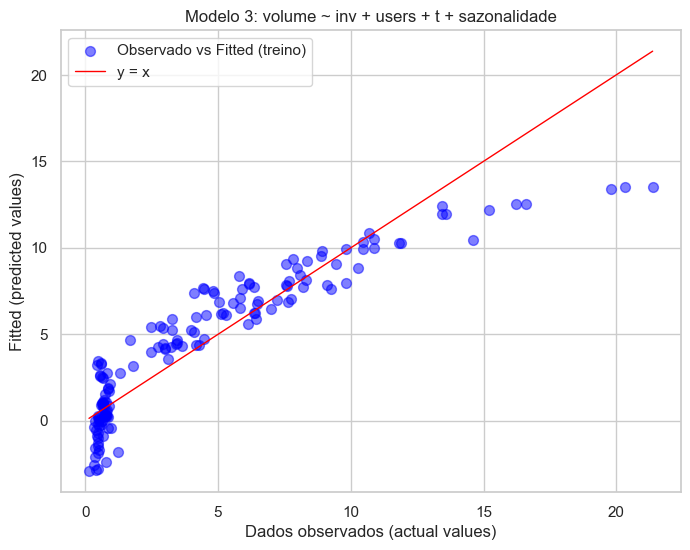

In [187]:

# Valores ajustados (in-sample)
fitted_values = model_multi_season.fittedvalues

# Valores observados
observed_values = train['volume']

plt.figure(figsize=(8,6))
plt.scatter(observed_values, fitted_values, s=50, color='blue', alpha=0.5, label='Observado vs Fitted (treino)')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', linewidth=1, label='y = x')
plt.xlabel('Dados observados (actual values)')
plt.ylabel('Fitted (predicted values)')
plt.title('Modelo 3: volume ~ inv + users + t + sazonalidade')
plt.grid(True)
plt.legend()
plt.show()


### Resíduos de séries temporais com três gráficos típicos:

Resíduos ao longo do tempo

Histograma ou densidade

ACF (autocorrelação dos resíduos)

Gráficos para o modelo  mais completo, que teve menor erro

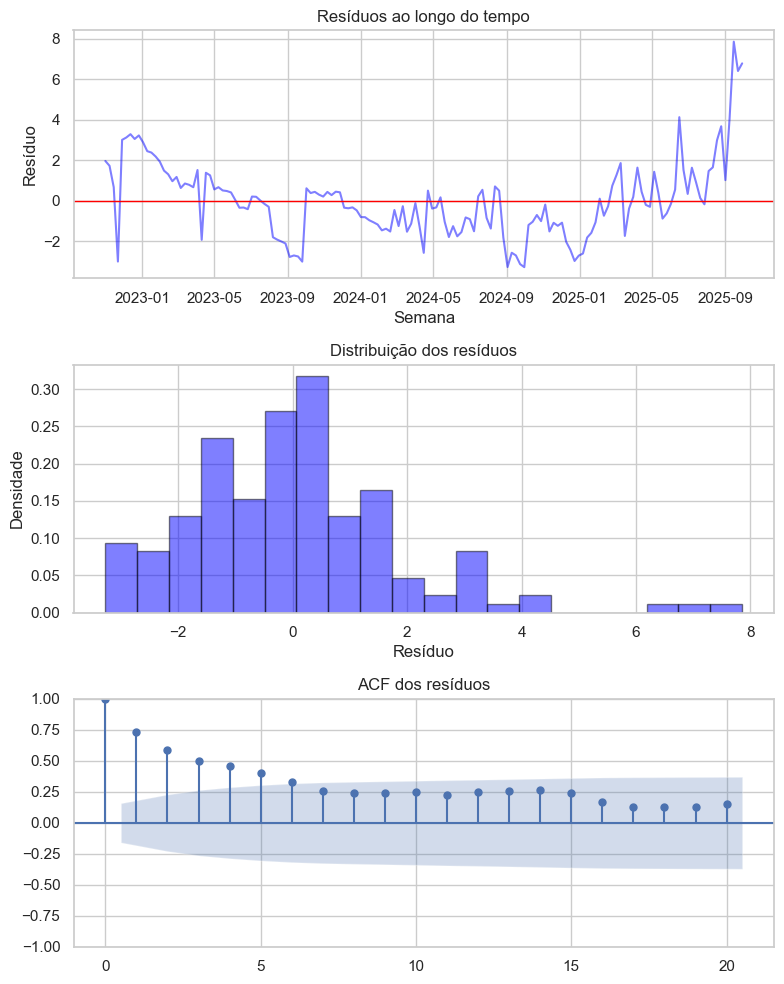

In [188]:


residuals = model_multi_season.resid  # resíduos in-sample

fig, axs = plt.subplots(3, 1, figsize=(8,10))

# 1) Resíduos ao longo do tempo
axs[0].plot(residuals.index, residuals, color='blue', alpha = 0.5)
axs[0].axhline(0, color='red', linewidth=1)
axs[0].set_title('Resíduos ao longo do tempo')
axs[0].set_xlabel('Semana')
axs[0].set_ylabel('Resíduo')
axs[0].grid(True)

# 2) Histograma / densidade
axs[1].hist(residuals, bins=20, color='blue', edgecolor='black', density=True, alpha = 0.5)
axs[1].set_title('Distribuição dos resíduos')
axs[1].set_xlabel('Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True)

# 3) ACF (autocorrelação)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axs[2])
axs[2].set_title('ACF dos resíduos')

plt.tight_layout()
plt.show()


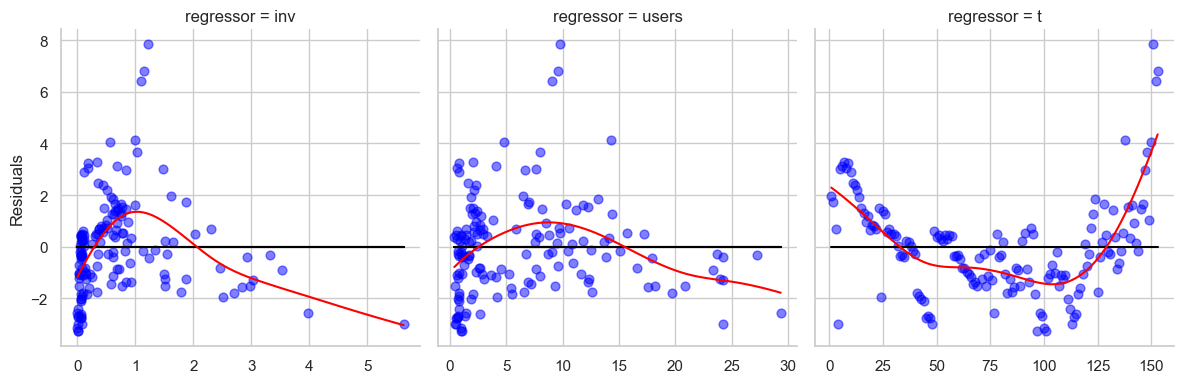

In [189]:
# Criar dataframe apenas com o treino + resíduos
df_train_resid = train.copy()
df_train_resid['residuals'] = model_multi_season.resid.values

# Escolha das regressoras para plot (exemplo)
regressors = ['inv', 'users', 't']  # substitua/adapte conforme suas colunas

# Transformar para formato longo
df_long = df_train_resid.melt(id_vars=['residuals'], 
                              value_vars=regressors,
                              var_name='regressor', value_name='x')

# Configurar Seaborn
sns.set(style="whitegrid")

# FacetGrid para plotar cada regressora
g = sns.FacetGrid(df_long, col="regressor", col_wrap=3, sharex=False, sharey=True, height=4)

def scatter_with_smooth(data, **kwargs):
    x = data['x'].values
    y = data['residuals'].values
    
    # Scatter
    plt.scatter(x, y, s=40, alpha=0.5, color='blue')
    
    # Ajuste linear
    coef = np.polyfit(x, y, 1)
    y_lin = coef[0]*x + coef[1]
    plt.plot(x, y_lin, color='black', linewidth=1.5, label='Linear')
    
    # Ajuste GAM (spline cúbica)
    gam = LinearGAM(s(0, n_splines=10)).fit(x.reshape(-1,1), y)
    XX = np.linspace(x.min(), x.max(), 100)
    plt.plot(XX, gam.predict(XX), color='red', linewidth=1.5, label='GAM')
    
    plt.xlabel('')
    plt.ylabel('Residuals')
    plt.legend()

g.map_dataframe(scatter_with_smooth)

plt.tight_layout()
plt.show()


## Cross - validation no modelo de regressão multipla com tendência e sazonalidade

### TimeSeriesSplit (sklearn) 

Funciona como k-fold, mas preserva o tempo e usa janelas progressivas.

In [190]:
h = 4  # horizonte de previsão
rmse_scores = []

for train_idx, test_idx in tscv.split(X):

    # Usa APENAS as primeiras h observações do test set
    test_idx_h = test_idx[:h]

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx_h]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx_h]

    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred = model.predict(sm.add_constant(X_test))

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    rmse_scores.append(rmse)

print("RMSE (h passos à frente):", rmse_scores)
print("RMSE médio:", np.mean(rmse_scores))


RMSE (h passos à frente): [np.float64(0.21190623582477444), np.float64(0.13393120301301714), np.float64(2.5810115340438813), np.float64(1.1055903584830775), np.float64(2.3367387672957833)]
RMSE médio: 1.2738356197321068


### Expanding Window CV (janela crescente)

Treina com um período crescente, testa no período seguinte.

TREINO: 1 2 3     | TESTE: 4

TREINO: 1 2 3 4   | TESTE: 5

TREINO: 1 2 3 4 5 | TESTE: 6


In [191]:
rmse_expanding = []

h = 4  # horizonte de previsão

for i in range(50, len(df)-h):  # começa com janela mínima (50)
    train = df.iloc[:i]
    test  = df.iloc[i:i+h]

    # X e y
    X_train = sm.add_constant(train[['inv','users','t']])
    y_train = train['volume']
    X_test = sm.add_constant(test[['inv','users','t']])

    model = sm.OLS(y_train, X_train).fit()
    pred = model.predict(X_test)

    rmse_expanding.append(np.sqrt(mean_squared_error(test['volume'], pred)))

print("RMSE médio (expanding window):", np.mean(rmse_expanding))


RMSE médio (expanding window): 2.1907702441699857


### Rolling Window CV (janela deslizante)

Treina sempre com o mesmo tamanho de janela.


TREINO: 1 2 3     | TESTE: 4

TREINO:   2 3 4   | TESTE: 5

TREINO:     3 4 5 | TESTE: 6


In [192]:
h = 4            # horizonte de previsão = 4 semanas
window = 52      # janela de treino = 1 ano
rmse_rolling = []

for i in range(window, len(df) - h):

    # ----- train e test -----
    train = df.iloc[i-window:i]
    test  = df.iloc[i:i+h]   # 4 semanas de teste

    # ----- X_train -----
    X_train = train[['inv','users','t']].astype(float)
    X_train = sm.add_constant(X_train, has_constant='add')
    y_train = train['volume']

    # ----- Ajustar modelo -----
    model = sm.OLS(y_train, X_train).fit()

    # ----- X_test -----
    X_test = test[['inv','users','t']].astype(float)
    X_test = sm.add_constant(X_test, has_constant='add')
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # ----- Previsão para 4 semanas -----
    pred = model.predict(X_test)

    # ----- RMSE das 4 semanas -----
    rmse = np.sqrt(mean_squared_error(test['volume'], pred))
    rmse_rolling.append(rmse)

print("RMSE médio (rolling 4 semanas à frente):", np.mean(rmse_rolling))


RMSE médio (rolling 4 semanas à frente): 1.9277918404804297


#### Como diferentes tipos de cross-validations se comportam

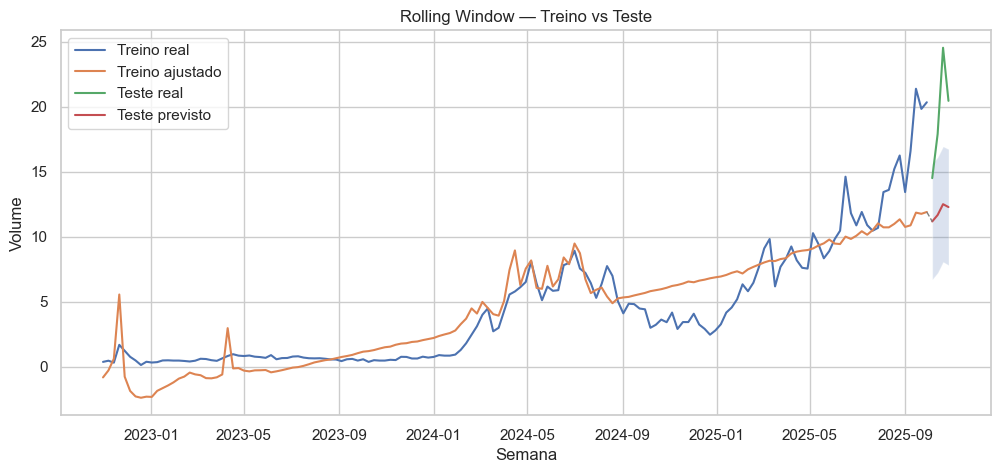

Rolling Window — RMSE: 8.08, MAE: 7.43, MAPE: 36.68%
Sumário salvo: summary_Rolling_Window.txt


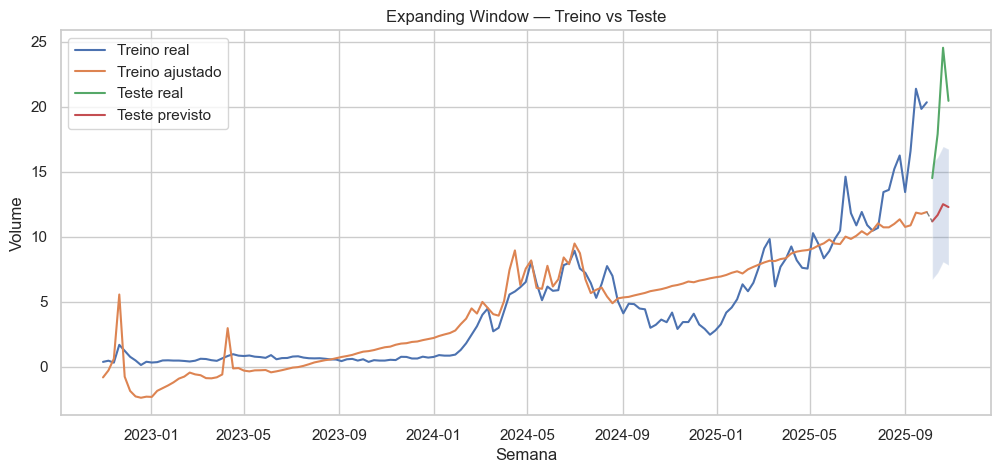

Expanding Window — RMSE: 8.08, MAE: 7.43, MAPE: 36.68%
Sumário salvo: summary_Expanding_Window.txt


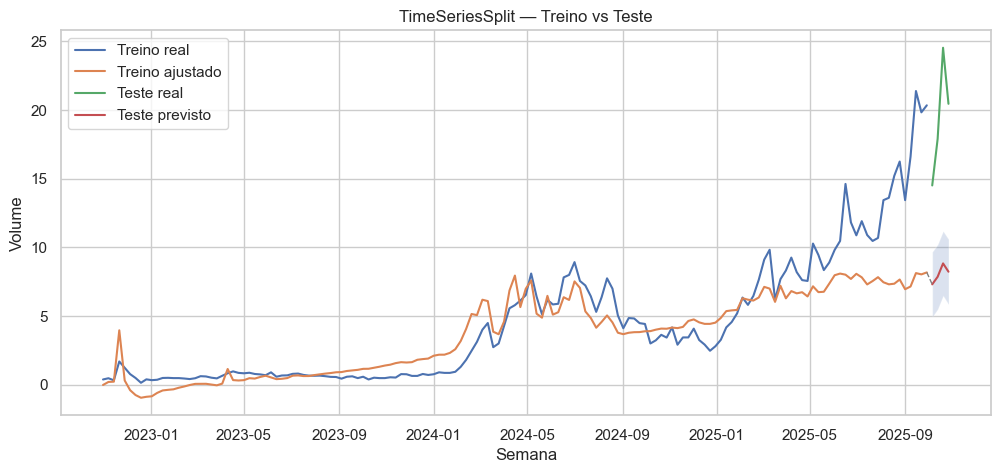

TimeSeriesSplit — RMSE: 11.71, MAE: 11.29, MAPE: 57.38%
Sumário salvo: summary_TimeSeriesSplit.txt


(np.float64(11.705702320644857),
 np.float64(11.2864088957057),
 np.float64(57.37984659751276))

In [193]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ============================================================
# CONFIGURAÇÕES
# ============================================================
X_cols = ['inv', 'users', 't']
target = 'volume'
h = 4  # horizonte de teste
window = 30  # janela rolling

# ------------------------------------------------------------
# Separar treino e teste
# ------------------------------------------------------------
train = df.iloc[:-h].copy()
test  = df.iloc[-h:].copy()

# ------------------------------------------------------------
# Função para plotar treino e teste e calcular métricas
# ------------------------------------------------------------
def plot_train_test(model, train, test, X_cols, model_name):
    # Predições no treino
    X_train = sm.add_constant(train[X_cols])
    X_train = X_train.reindex(columns=model.model.exog_names, fill_value=0)
    pred_train = model.get_prediction(X_train).summary_frame(alpha=0.05)
    
    # Predições no teste
    X_test = sm.add_constant(test[X_cols])
    X_test = X_test.reindex(columns=model.model.exog_names, fill_value=0)
    pred_test = model.get_prediction(X_test).summary_frame(alpha=0.05)
    
    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(train.index, train[target], label='Treino real')
    plt.plot(train.index, pred_train['mean'], label='Treino ajustado')
    plt.plot(test.index, test[target], label='Teste real')
    plt.plot(test.index, pred_test['mean'], label='Teste previsto')
    plt.fill_between(test.index, pred_test['obs_ci_lower'], pred_test['obs_ci_upper'], alpha=0.2)
    # Conectar último ponto do treino com primeiro do teste
    plt.plot([train.index[-1], test.index[0]], 
             [pred_train['mean'].iloc[-1], pred_test['mean'].iloc[0]], 
             color='gray', linestyle='--', linewidth=1)
    
    plt.title(f'{model_name} — Treino vs Teste')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Métricas
    y_true = test[target]
    y_pred = pred_test['mean']
    rmse_val = np.sqrt(np.mean((y_true - y_pred)**2))
    mae_val = np.mean(np.abs(y_true - y_pred))
    mape_val = np.mean(np.abs((y_true - y_pred)/y_true))*100
    print(f"{model_name} — RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}, MAPE: {mape_val:.2f}%")
    
    # Salvar sumário
    with open(f'summary_{model_name.replace(" ", "_")}.txt', 'w') as f:
        f.write(model.summary().as_text())
    
    print(f"Sumário salvo: summary_{model_name.replace(' ', '_')}.txt")
    
    return rmse_val, mae_val, mape_val

# ============================================================
# MODELOS
# ============================================================
# 1) Rolling Window final
model_final_rw = sm.OLS(train[target], sm.add_constant(train[X_cols])).fit()

# 2) Expanding Window final
model_final_exp = sm.OLS(df[target].iloc[:-h], sm.add_constant(df[X_cols].iloc[:-h])).fit()

# 3) TimeSeriesSplit último fold
tscv = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tscv.split(df))[-1]
model_final_tscv = sm.OLS(df[target].iloc[train_idx], sm.add_constant(df[X_cols].iloc[train_idx])).fit()

# ============================================================
# PLOTS E MÉTRICAS
# ============================================================
plot_train_test(model_final_rw, train, test, X_cols, 'Rolling Window')
plot_train_test(model_final_exp, train, test, X_cols, 'Expanding Window')
plot_train_test(model_final_tscv, train, test, X_cols, 'TimeSeriesSplit')


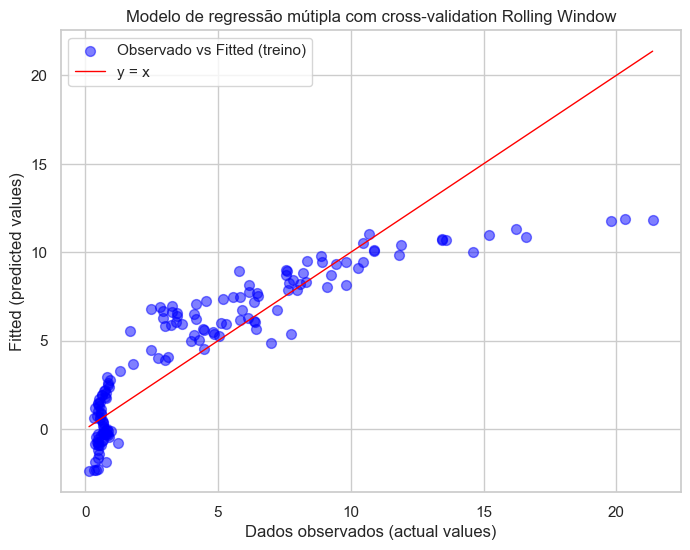

In [194]:

# Valores ajustados (in-sample)
fitted_values = model_final_rw.fittedvalues

# Valores observados
observed_values = train['volume']

plt.figure(figsize=(8,6))
plt.scatter(observed_values, fitted_values, s=50, color='blue', alpha=0.5, label='Observado vs Fitted (treino)')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', linewidth=1, label='y = x')
plt.xlabel('Dados observados (actual values)')
plt.ylabel('Fitted (predicted values)')
plt.title('Modelo de regressão mútipla com cross-validation Rolling Window')
plt.grid(True)
plt.legend()
plt.show()


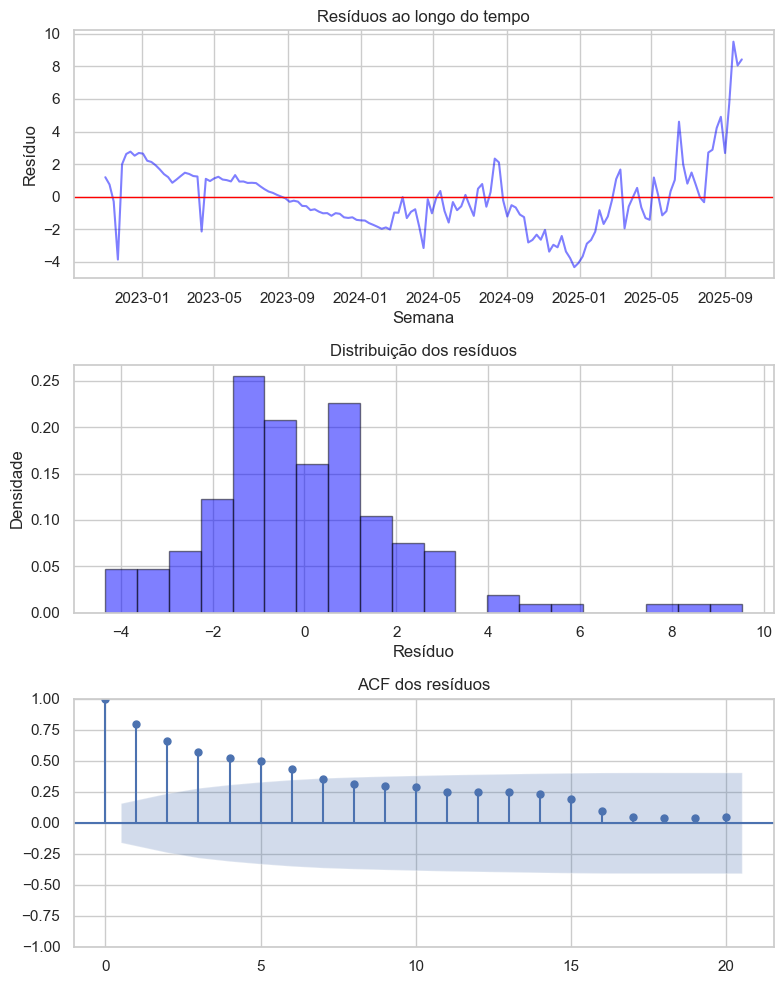

In [195]:


residuals = model_final_rw.resid  # resíduos in-sample

fig, axs = plt.subplots(3, 1, figsize=(8,10))

# 1) Resíduos ao longo do tempo
axs[0].plot(residuals.index, residuals, color='blue', alpha = 0.5)
axs[0].axhline(0, color='red', linewidth=1)
axs[0].set_title('Resíduos ao longo do tempo')
axs[0].set_xlabel('Semana')
axs[0].set_ylabel('Resíduo')
axs[0].grid(True)

# 2) Histograma / densidade
axs[1].hist(residuals, bins=20, color='blue', edgecolor='black', density=True, alpha = 0.5)
axs[1].set_title('Distribuição dos resíduos')
axs[1].set_xlabel('Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True)

# 3) ACF (autocorrelação)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axs[2])
axs[2].set_title('ACF dos resíduos')

plt.tight_layout()
plt.show()


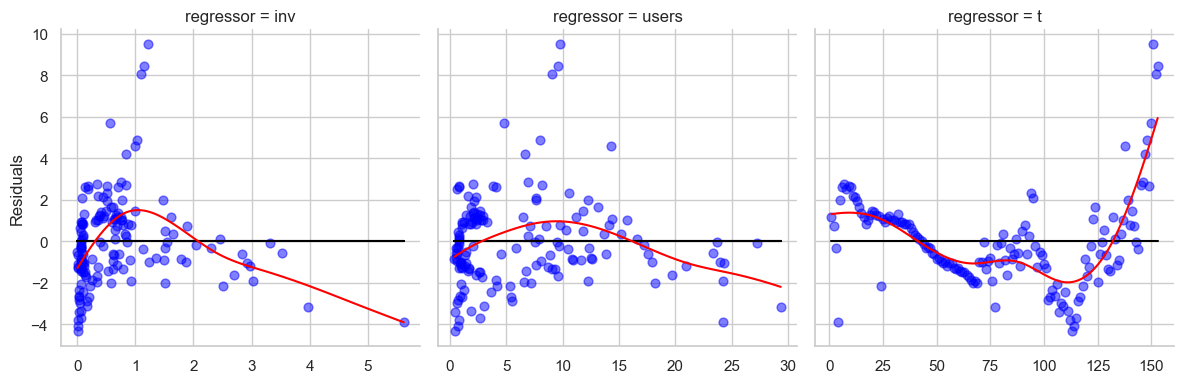

In [196]:
# Criar dataframe apenas com o treino + resíduos
df_train_resid = train.copy()
df_train_resid['residuals'] = model_final_rw.resid.values

# Escolha das regressoras para plot (exemplo)
regressors = ['inv', 'users', 't']  # substitua/adapte conforme suas colunas

# Transformar para formato longo
df_long = df_train_resid.melt(id_vars=['residuals'], 
                              value_vars=regressors,
                              var_name='regressor', value_name='x')

# Configurar Seaborn
sns.set(style="whitegrid")

# FacetGrid para plotar cada regressora
g = sns.FacetGrid(df_long, col="regressor", col_wrap=3, sharex=False, sharey=True, height=4)

def scatter_with_smooth(data, **kwargs):
    x = data['x'].values
    y = data['residuals'].values
    
    # Scatter
    plt.scatter(x, y, s=40, alpha=0.5, color='blue')
    
    # Ajuste linear
    coef = np.polyfit(x, y, 1)
    y_lin = coef[0]*x + coef[1]
    plt.plot(x, y_lin, color='black', linewidth=1.5, label='Linear')
    
    # Ajuste GAM (spline cúbica)
    gam = LinearGAM(s(0, n_splines=10)).fit(x.reshape(-1,1), y)
    XX = np.linspace(x.min(), x.max(), 100)
    plt.plot(XX, gam.predict(XX), color='red', linewidth=1.5, label='GAM')
    
    plt.xlabel('')
    plt.ylabel('Residuals')
    plt.legend()

g.map_dataframe(scatter_with_smooth)

plt.tight_layout()
plt.show()


### Tranformação Box-Cox e Log

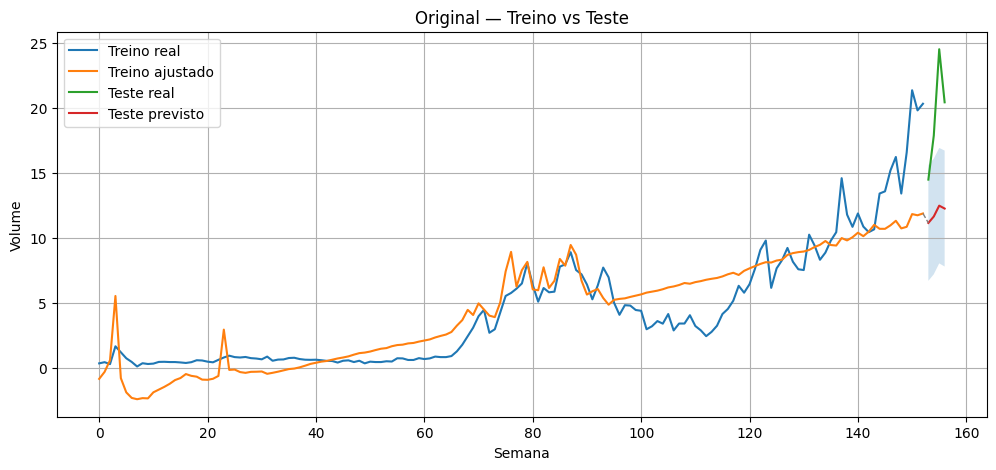

Original — RMSE: 8.08, MAE: 7.43, MAPE: 36.68%
Sumário salvo: summary_Original.txt


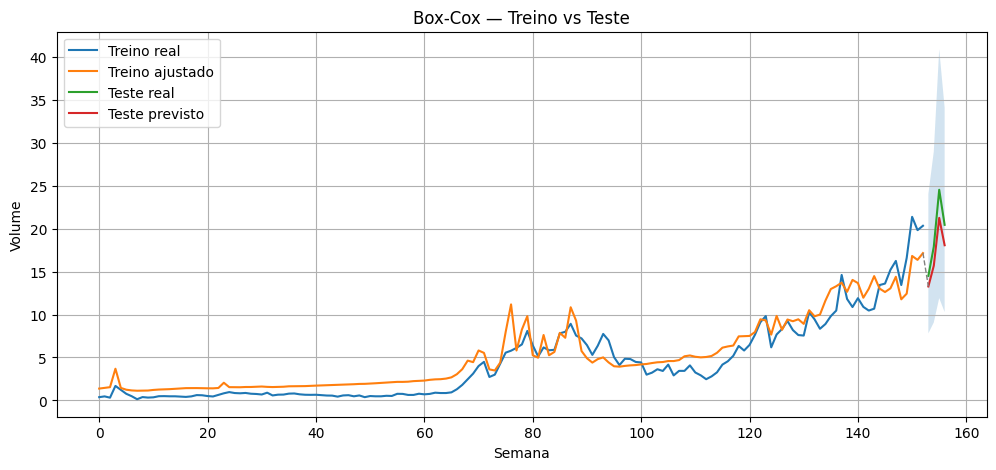

Box-Cox — RMSE: 2.39, MAE: 2.27, MAPE: 11.46%
Sumário salvo: summary_Box-Cox.txt


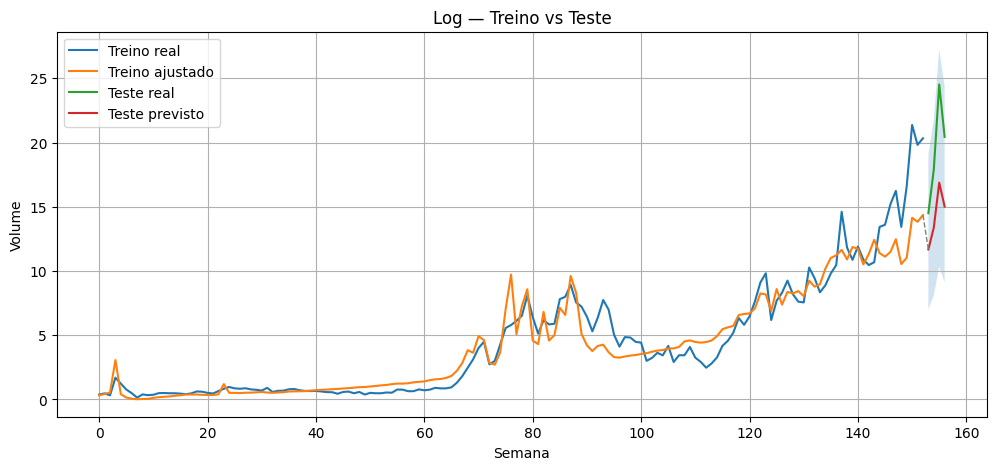

Log — RMSE: 5.39, MAE: 5.10, MAPE: 25.60%
Sumário salvo: summary_Log.txt

===== COMPARAÇÃO FINAL DOS MODELOS =====
     Modelo      RMSE       MAE   MAPE (%)
0   Box-Cox  2.386013  2.273263  11.458031
1       Log  5.388765  5.100882  25.602845
2  Original  8.077409  7.434484  36.678719


In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ============================================================
# CONFIGURAÇÕES
# ============================================================
df = pd.read_csv("data_updated.csv")
X_cols = ['inv', 'users', 't']
target = 'volume'
h = 4  # horizonte de teste
window = 30  # tamanho da janela rolling

# Criar coluna t como índice sequencial
df['t'] = np.arange(len(df))

# Separar treino e teste
train = df.iloc[:-h].copy()
test  = df.iloc[-h:].copy()

# ============================================================
# FUNÇÃO DE PLOT E MÉTRICAS
# ============================================================
def plot_train_test(model, train, test, X_cols, model_name, transform=None, lambda_bc=None):
    # Predições no treino
    X_train = sm.add_constant(train[X_cols])
    X_train = X_train.reindex(columns=model.model.exog_names, fill_value=0)
    pred_train = model.get_prediction(X_train).summary_frame(alpha=0.05)
    
    # Predições no teste
    X_test = sm.add_constant(test[X_cols])
    X_test = X_test.reindex(columns=model.model.exog_names, fill_value=0)
    pred_test = model.get_prediction(X_test).summary_frame(alpha=0.05)
    
    # Inverter transformação se houver
    if transform == "boxcox":
        pred_train['mean'] = inv_boxcox(pred_train['mean'], lambda_bc)
        pred_train['obs_ci_lower'] = inv_boxcox(pred_train['obs_ci_lower'], lambda_bc)
        pred_train['obs_ci_upper'] = inv_boxcox(pred_train['obs_ci_upper'], lambda_bc)
        pred_test['mean'] = inv_boxcox(pred_test['mean'], lambda_bc)
        pred_test['obs_ci_lower'] = inv_boxcox(pred_test['obs_ci_lower'], lambda_bc)
        pred_test['obs_ci_upper'] = inv_boxcox(pred_test['obs_ci_upper'], lambda_bc)
    elif transform == "log":
        pred_train['mean'] = np.exp(pred_train['mean']) - 1
        pred_train['obs_ci_lower'] = np.exp(pred_train['obs_ci_lower']) - 1
        pred_train['obs_ci_upper'] = np.exp(pred_train['obs_ci_upper']) - 1
        pred_test['mean'] = np.exp(pred_test['mean']) - 1
        pred_test['obs_ci_lower'] = np.exp(pred_test['obs_ci_lower']) - 1
        pred_test['obs_ci_upper'] = np.exp(pred_test['obs_ci_upper']) - 1

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(train.index, train[target], label='Treino real')
    plt.plot(train.index, pred_train['mean'], label='Treino ajustado')
    plt.plot(test.index, test[target], label='Teste real')
    plt.plot(test.index, pred_test['mean'], label='Teste previsto')
    plt.fill_between(test.index, pred_test['obs_ci_lower'], pred_test['obs_ci_upper'], alpha=0.2)
    plt.plot([train.index[-1], test.index[0]], 
             [pred_train['mean'].iloc[-1], pred_test['mean'].iloc[0]], 
             color='gray', linestyle='--', linewidth=1)
    plt.title(f'{model_name} — Treino vs Teste')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Métricas no teste
    y_true = test[target]
    y_pred = pred_test['mean']
    rmse_val = np.sqrt(np.mean((y_true - y_pred)**2))
    mae_val = np.mean(np.abs(y_true - y_pred))
    mape_val = np.mean(np.abs((y_true - y_pred)/y_true))*100
    print(f"{model_name} — RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}, MAPE: {mape_val:.2f}%")
    
    # Salvar sumário
    with open(f'summary_{model_name.replace(" ", "_")}.txt', 'w') as f:
        f.write(model.summary().as_text())
    print(f"Sumário salvo: summary_{model_name.replace(' ', '_')}.txt")
    
    return rmse_val, mae_val, mape_val

# ============================================================
# MODELOS
# ============================================================
results = []

# 1) Original
model_orig = sm.OLS(train[target], sm.add_constant(train[X_cols])).fit()
rmse_orig, mae_orig, mape_orig = plot_train_test(model_orig, train, test, X_cols, "Original")
results.append({"Modelo": "Original", "RMSE": rmse_orig, "MAE": mae_orig, "MAPE (%)": mape_orig})

# 2) Box-Cox
y_train_bc, lambda_bc = boxcox(train[target] + 1)
model_bc = sm.OLS(y_train_bc, sm.add_constant(train[X_cols])).fit()
rmse_bc, mae_bc, mape_bc = plot_train_test(model_bc, train, test, X_cols, "Box-Cox", transform="boxcox", lambda_bc=lambda_bc)
results.append({"Modelo": "Box-Cox", "RMSE": rmse_bc, "MAE": mae_bc, "MAPE (%)": mape_bc})

# 3) Log
y_train_log = np.log(train[target] + 1)
model_log = sm.OLS(y_train_log, sm.add_constant(train[X_cols])).fit()
rmse_log, mae_log, mape_log = plot_train_test(model_log, train, test, X_cols, "Log", transform="log")
results.append({"Modelo": "Log", "RMSE": rmse_log, "MAE": mae_log, "MAPE (%)": mape_log})

# ============================================================
# TABELA FINAL DE COMPARAÇÃO
# ============================================================
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("RMSE").reset_index(drop=True)
print("\n===== COMPARAÇÃO FINAL DOS MODELOS =====")
print(df_results)


Análise dos resíduos

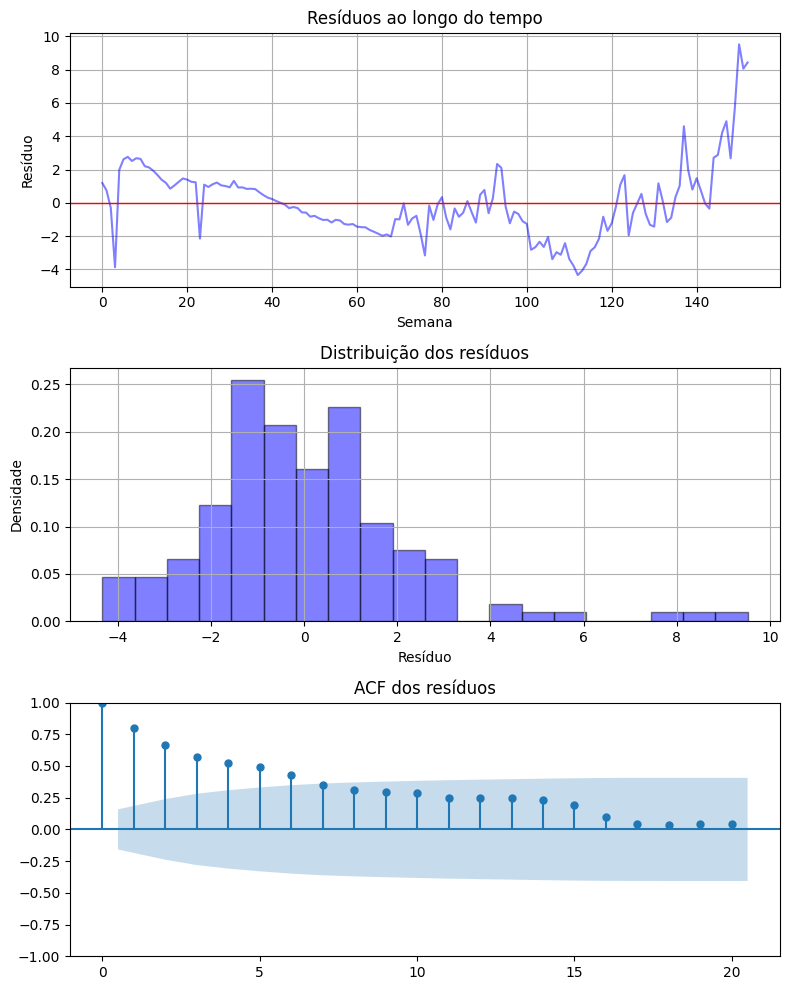

In [8]:
residuals = model_orig.resid  

fig, axs = plt.subplots(3, 1, figsize=(8,10))

# 1) Resíduos ao longo do tempo
axs[0].plot(residuals.index, residuals, color='blue', alpha = 0.5)
axs[0].axhline(0, color='red', linewidth=1)
axs[0].set_title('Resíduos ao longo do tempo')
axs[0].set_xlabel('Semana')
axs[0].set_ylabel('Resíduo')
axs[0].grid(True)

# 2) Histograma / densidade
axs[1].hist(residuals, bins=20, color='blue', edgecolor='black', density=True, alpha = 0.5)
axs[1].set_title('Distribuição dos resíduos')
axs[1].set_xlabel('Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True)

# 3) ACF (autocorrelação)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axs[2])
axs[2].set_title('ACF dos resíduos')

plt.tight_layout()
plt.show()


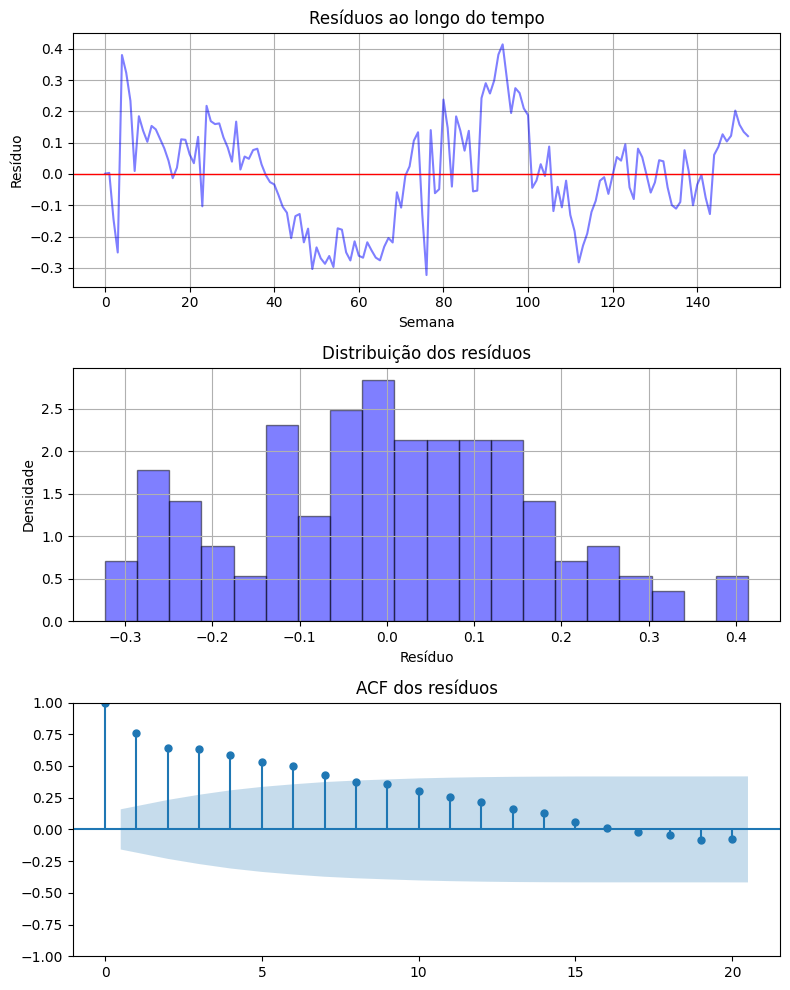

In [7]:
residuals = model_bc.resid  

fig, axs = plt.subplots(3, 1, figsize=(8,10))

# 1) Resíduos ao longo do tempo
axs[0].plot(residuals.index, residuals, color='blue', alpha = 0.5)
axs[0].axhline(0, color='red', linewidth=1)
axs[0].set_title('Resíduos ao longo do tempo')
axs[0].set_xlabel('Semana')
axs[0].set_ylabel('Resíduo')
axs[0].grid(True)

# 2) Histograma / densidade
axs[1].hist(residuals, bins=20, color='blue', edgecolor='black', density=True, alpha = 0.5)
axs[1].set_title('Distribuição dos resíduos')
axs[1].set_xlabel('Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True)

# 3) ACF (autocorrelação)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axs[2])
axs[2].set_title('ACF dos resíduos')

plt.tight_layout()
plt.show()


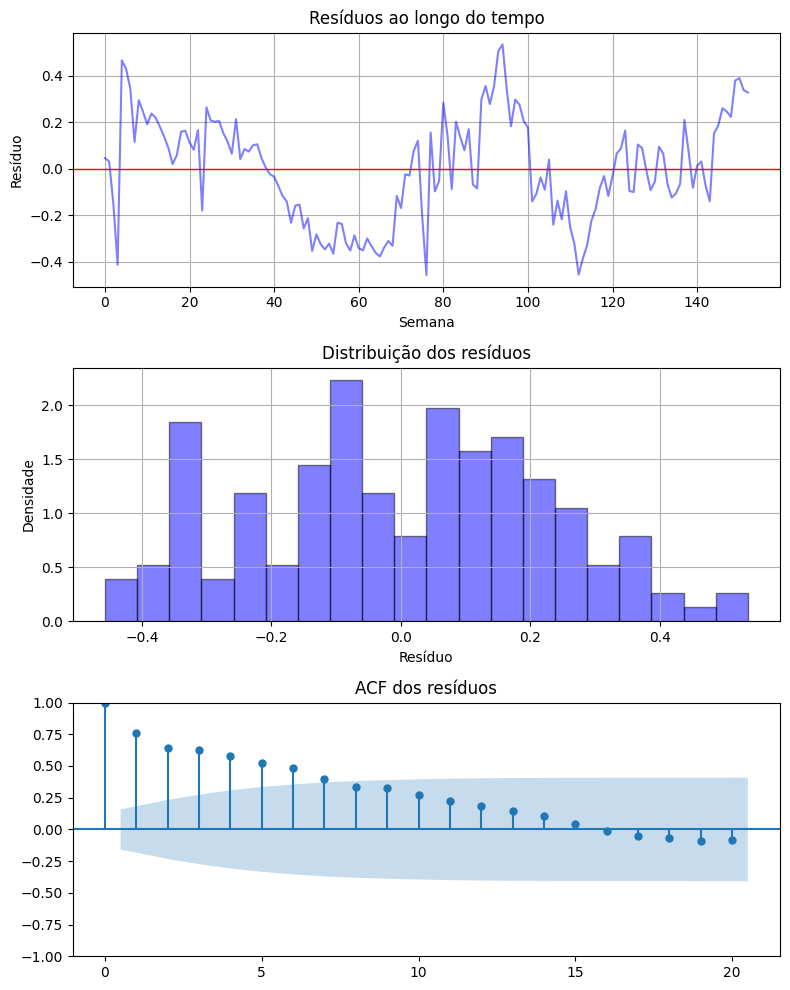

In [9]:
residuals = model_log.resid  

fig, axs = plt.subplots(3, 1, figsize=(8,10))

# 1) Resíduos ao longo do tempo
axs[0].plot(residuals.index, residuals, color='blue', alpha = 0.5)
axs[0].axhline(0, color='red', linewidth=1)
axs[0].set_title('Resíduos ao longo do tempo')
axs[0].set_xlabel('Semana')
axs[0].set_ylabel('Resíduo')
axs[0].grid(True)

# 2) Histograma / densidade
axs[1].hist(residuals, bins=20, color='blue', edgecolor='black', density=True, alpha = 0.5)
axs[1].set_title('Distribuição dos resíduos')
axs[1].set_xlabel('Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True)

# 3) ACF (autocorrelação)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axs[2])
axs[2].set_title('ACF dos resíduos')

plt.tight_layout()
plt.show()


Com base nos erros, ajustes e análise dos resíduos, podemos ver que as transformações, em especial a Box-Cox, melhoram bastante o modelo.